In [235]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


# Multinomial regression

Set a seed for reproducibility:

In [236]:
SEED = 42

In [237]:
import matplotlib.pyplot as plt
import numpy as np

np.random.seed(SEED)

## Pre-activation (score computation)

Let $\mathbf{W}_{(d+1)\times k} = [\mathbf{w}_1, \mathbf{w}_2, \ldots, \mathbf{w}_k]$ be the weight matrix, where $\mathbf{w}_i$ is the weight vector for class $i \in \{1, 2, \ldots, k\}$ augmented with the bias term. The scores $\mathbf{z} = [z_1, \ldots, z_k]^T$ computed for the linear model for an input $\mathbf{x}$ are given by

$$
\mathbf{z} = \mathbf{W}^T \mathbf{x},
$$

where $z_i$ is the score for class $i$.

In [238]:
W = np.random.randn(5, 3) # 4 features + 1 bias, 3 classes
x = np.random.randn(5, 1) # 4 features + 1 bias
x[-1] = 1 # bias
z = np.dot(W.T, x) # 3 classes 

print(f"x:\n {x}\n")
print(f"z:\n {z}")

x:
 [[-0.56228753]
 [-1.01283112]
 [ 0.31424733]
 [-0.90802408]
 [ 1.        ]]

z:
 [[-1.57630011]
 [-0.93641939]
 [-1.57660107]]


## From scores to probabilities

### Softmax activation

The softmax function is a generalization of the logistic function to multiple dimensions. It is used in multinomial logistic regression and is defined as:

$$
\text{softmax}(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}
$$

where $\mathbf{z}$ is a vector of real numbers, and $k$ is the number of classes. The softmax function maps the input vector to a probability distribution over the classes.

$\text{softmax}(\mathbf{z})$

In [239]:
softmax = lambda z: np.exp(z) / np.sum(np.exp(z))
z = np.array([0.45, 0.5])
print(softmax(z))
print(np.sum(softmax(z)))

[0.4875026 0.5124974]
1.0


$\text{softmax}(\mathbf{z})$, where $\mathbf{z} = [v, 0]$

In [240]:
softmax = lambda z: np.exp(z) / np.sum(np.exp(z))
v = 0.45
z = np.array([v, 0])
sigmoid = lambda x: 1 / (1 + np.exp(-x))

print(sigmoid(v), 1-sigmoid(v))
print(softmax(z))

0.610639233949222 0.38936076605077796
[0.61063923 0.38936077]


$\text{softmax}(\mathbf{z} + \Delta)$

In [241]:
z1 = np.array([0.45, 0.5])
z2 = z1 + 10

print(softmax(z1))
print(softmax(z2))

[0.4875026 0.5124974]
[0.4875026 0.5124974]


$\text{softmax}(\alpha \cdot \mathbf{z})$

In [242]:
z = np.array([0.45, 0.5])
for alpha in np.logspace(-2, 2, 5):
    print(f"{alpha:.2f} {softmax(alpha*z)}")

0.01 [0.499875 0.500125]
0.10 [0.49875 0.50125]
1.00 [0.4875026 0.5124974]
10.00 [0.37754067 0.62245933]
100.00 [0.00669285 0.99330715]



### Classification model

For a sample $\mathbf{x}$, the output of the model is:

$$
\hat{\mathbf{y}} = \text{softmax}(\mathbf{W}^T \mathbf{x}),
$$

where $\mathbf{W}$ is a matrix of weights (including the bias term). The prediction $\hat{\mathbf{y}} = [\hat{y}_1, \ldots, \hat{y}_k]^T $ is a probability distribution over the classes. In other words, $\hat{y}_i$ is the probability that the input $\mathbf{x}$ belongs to class $i$.

In [243]:
W = np.random.randn(5, 3)  # 4 features + 1 bias, 3 classes
x = np.random.randn(5, 1)  # 4 features + 1 bias
x[-1] = 1  # bias
z = np.dot(W.T, x)  # 3 classes
y_pred = softmax(z)
print(f"x:\n {x}\n")
print(f"z:\n {z}\n")
print(f"y_pred:\n {y_pred}")

print(f"sum over probs: {y_pred.sum():.2f}")

x:
 [[-1.22084365]
 [ 0.2088636 ]
 [-1.95967012]
 [-1.32818605]
 [ 1.        ]]

z:
 [[ 0.54258805]
 [-0.83284095]
 [-0.51984512]]

y_pred:
 [[0.62564715]
 [0.15812052]
 [0.21623232]]
sum over probs: 1.00


## Optimization model
### Cross-entropy loss

Recall the definition of cross-entropy:

$$
H(p, q) = -\sum_i p_i \log(q_i).
$$

For *multinomial regression*, given a training sample $\mathbf{x}$ belongin to a classe $c \in \{1, 2, \ldots, k\}$, the distributions $p$ and $q$ are given by

$$
p_i = \begin{cases}
1 & \text{if } i = c \\
0 & \text{otherwise}
\end{cases}
$$

and

$$
q_i = \hat{y}_i = \frac{e^{z_i}}{\sum_{j=1}^{k} e^{z_j}}.
$$ 

The cross-entropy loss is given by

$$
L = -\sum_i p_i \log(q_i) = -\log(q_c) = -\log(\hat{y}_c).
$$

In other words, the loss is the negative log of the predicted probability of the true class ($c$-th softmax output).

In [244]:
c = 1 # k = 3 classes
loss = -np.log(y_pred[c, 0])
print(f"loss: {loss:.2f}")

loss: 1.84


### Gradient derivation

The gradient of the loss with respect to the weights is given by

$$
\frac{\partial L}{\partial w_{ij}} = \frac{\partial L}{\partial \hat{y}_c} \frac{\partial \hat{y}_c}{\partial z_j} \frac{\partial z_j}{\partial w_{ij}}.
$$

#### Loss derivative with respect to the softmax output

The derivative of the loss with respect to the $c$-th element of the softmax output is given by

$$
\frac{\partial L}{\partial \hat{y}_c} = -\frac{1}{\hat{y}_c}.
$$

#### Softmax derivative

The derivative of the softmax function with respect to $z_j$ is given by

$$
\frac{\partial \hat{y}_c}{\partial z_j} = \begin{cases}
\hat{y}_j(1 - \hat{y}_j) & \text{if } j = c \\
-\hat{y}_c \hat{y}_j & \text{otherwise}
\end{cases}.
$$

#### Score derivative

The derivative of the score $z_j$ with respect to the weight $w_{ij}$ is given by

$$
\frac{\partial z_j}{\partial w_{ij}} = x_i.
$$

Putting it all together, we have

$$
\frac{\partial L}{\partial w_{ij}} = \begin{cases}
(\hat{y}_j - 1) x_i & \text{if } j = c \\
\hat{y}_j x_i & \text{otherwise}
\end{cases}.
$$

### Multinomial regression algorithm

1. Initialize the weights $\mathbf{W}$.
2. For each epoch:
    1. For each training sample $\mathbf{x}$:
        1. Compute the scores $\mathbf{z} = \mathbf{W}^T \mathbf{x}$.
        2. Compute the softmax output $\hat{\mathbf{y}} = \text{softmax}(\mathbf{z})$.
        3. Compute the loss $L = -\log(\hat{y}_c)$.
        5. For each weight $w_{ij}$ in $\mathbf{W}$:
            1. Update the weight $w_{ij} = w_{ij} - \alpha \frac{\partial L}{\partial w_{ij}}$.

Train set size: 800
Test set size: 200


X_train_min: -2.7006378421518584, X_train_max: 3.056834530918784
ymin: 0, ymax: 2


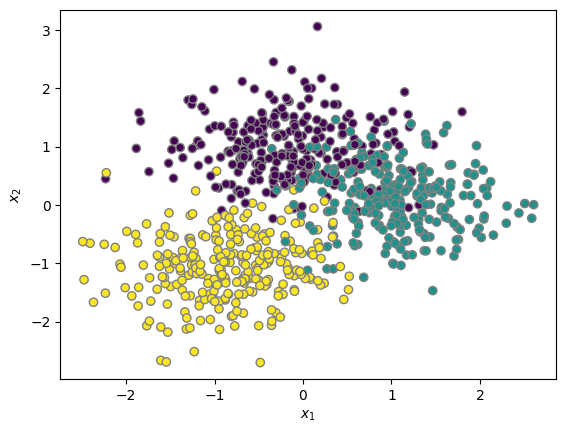

In [245]:
from utils import make_classification_dataset, standard_scaler
from sklearn.model_selection import train_test_split

np.random.seed(SEED)

num_classes = 3  # number
X, y = make_classification_dataset(1000, 2, num_classes, cluster_std=4)


# Train/test split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)


# Standardize X
X_train, mean, std = standard_scaler(X_train)
X_test, _, _ = standard_scaler(X_test, mean, std)

print(f"Train set size: {len(X_train)}")
print(f"Test set size: {len(X_test)}")

# Plot the dataset
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train, edgecolors="gray")
plt.xlabel("$x_1$")
plt.ylabel("$x_2$")

print(f"X_train_min: {X_train.min()}, X_train_max: {X_train.max()}")

print(f"ymin: {y.min()}, ymax: {y.max()}")

### Training

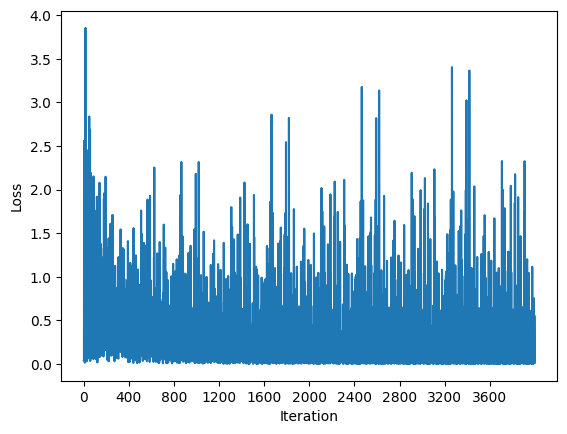

In [246]:
from utils import plot_loss_history

np.random.seed(SEED)

num_epochs = 5
learning_rate = 1e-02

# Add a bias term
X_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

# Random weights initialization
W = np.random.normal(size=(X_b.shape[1], num_classes)) # 2 features + 1 bias, 3 classes

iteration = 0
loss_history = []
for epoch in range(num_epochs):
    for k in range(len(X_b)):
        x = X_b[k].reshape(-1, 1) # make it a column vector

        # Forward pass
        y_pred = softmax(np.dot(W.T, x))

        # Loss
        correct_class = y_train[k]
        loss_value = -np.log(y_pred[correct_class, 0])
        loss_history.append(loss_value)

        # Update weights
        for i in range(W.shape[0]):
            for j in range(W.shape[1]):
                grad = (y_pred[j, 0] - 1) * x[i, 0] if j == correct_class else y_pred[j, 0] * x[i, 0]
                W[i, j] = W[i, j] - learning_rate * grad

        iteration += 1
plot_loss_history(loss_history, interval=iteration // 10)

### Test

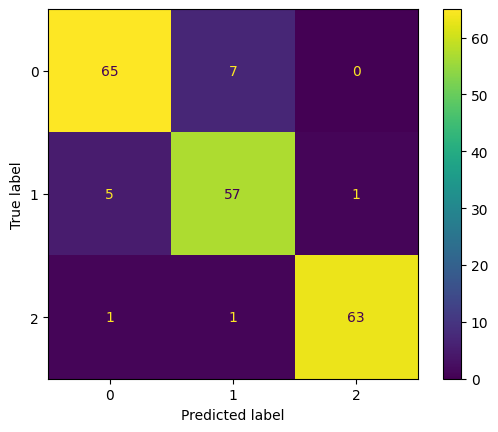


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        72
           1       0.88      0.90      0.89        63
           2       0.98      0.97      0.98        65

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



In [247]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

X_b = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

y_pred = []
for k in range(len(X_b)):
    x = X_b[k].reshape(-1, 1)  # make it a column vector
    z = np.dot(W.T, x)
    y_pred.append(np.argmax(z))
y_pred = np.array(y_pred)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

### Vectorized form

We have seen that the gradient of the loss with respect to the weights is given by

$$
\frac{\partial L}{\partial w_{ij}} = \begin{cases}
(\hat{y}_j - 1) x_i & \text{if } j = c \\
\hat{y}_j x_i & \text{otherwise}
\end{cases}.
$$

In a vectorized form, the gradient of the loss with respect to the weights is given by

$$
\begin{align*}
\frac{\partial L}{\partial \mathbf{W}} &= \begin{bmatrix}
\hat{y}_1 x_1 & \ldots & (\hat{y}_c - 1) x_1 & \ldots & \hat{y}_k x_1 \\
\vdots & \ddots & \vdots & \ddots & \vdots \\
\hat{y}_1 x_{d+1} & \ldots & (\hat{y}_c - 1) x_{d+1} & \ldots & \hat{y}_k x_{d+1}
\end{bmatrix}\\
& = \begin{bmatrix}
\hat{y}_1 \mathbf{x} & \ldots & (\hat{y}_c - 1) \mathbf{x} & \ldots & \hat{y}_k \mathbf{x}
\end{bmatrix}\\
& = \mathbf{x} (\hat{\mathbf{y}} - \mathbf{p})^T,
\end{align*}
$$

where $\mathbf{\hat{y}}$ is the predicted probability distribution over the classes and $\mathbf{p}$ is the one-hot encoded vector of the true class.

Alternatively, we can compute $\frac{\partial L}{\partial \mathbf{W}}$ as the matrix $M = \mathbf{x} \hat{\mathbf{y}}^T$ and subtract 1 from the $c$-th column of $M$.

### Multinomial regression algorithm

1. Initialize the weights $\mathbf{W}$.
2. For each epoch:
    1. For each training sample $\mathbf{x}$:
        1. Compute the scores $\mathbf{z} = \mathbf{W}^T \mathbf{x}$.
        2. Compute the softmax output $\hat{\mathbf{y}} = \text{softmax}(\mathbf{z})$.
        3. Compute the loss $L = -\log(\hat{y}_c)$.
        5. Update the weights $\mathbf{W} = \mathbf{W} - \alpha \mathbf{x} (\hat{\mathbf{y}} - \mathbf{p})^T$.

### Training

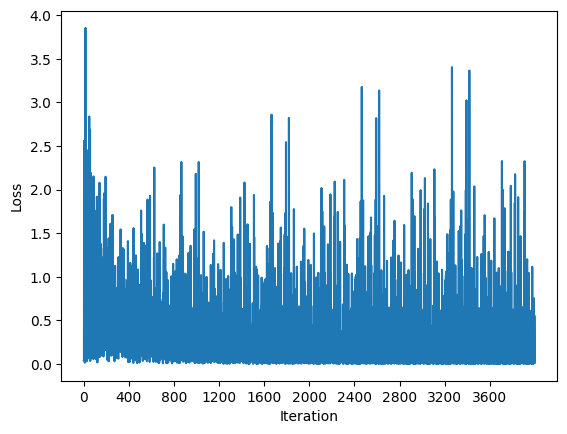

In [248]:
from utils import onehot

np.random.seed(SEED)

# Add a bias term
X_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

# Random weights initialization
W = np.random.normal(size=(X_b.shape[1], num_classes))  # 2 features + 1 bias, 3 classes

iteration = 0
loss_history = []
for epoch in range(num_epochs):
    for k in range(len(X_b)):
        x = X_b[k].reshape(-1, 1)  # make it a column vector

        # Forward pass
        y_pred = softmax(np.dot(W.T, x))

        # Loss
        correct_class = y_train[k]
        loss_value = -np.log(y_pred[correct_class, 0])
        loss_history.append(loss_value)

        # Update weights
        p = onehot([correct_class], num_classes).reshape(-1, 1) # make it a column vector
        grad = np.dot(x, (y_pred - p).T)

        # Alternative way to calculate the gradient
        # y_pred[correct_class] -= 1
        # grad = np.dot(x, y_pred.T)

        W = W - learning_rate * np.dot(x, (y_pred - p).T)

        iteration += 1
plot_loss_history(loss_history, interval=iteration // 10)

### Test

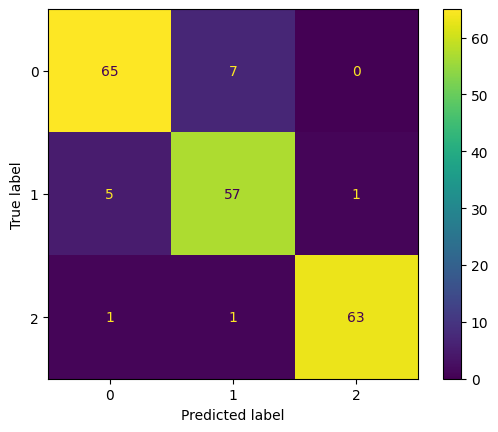


Classification Report:
              precision    recall  f1-score   support

           0       0.92      0.90      0.91        72
           1       0.88      0.90      0.89        63
           2       0.98      0.97      0.98        65

    accuracy                           0.93       200
   macro avg       0.93      0.93      0.93       200
weighted avg       0.93      0.93      0.93       200



In [249]:
from sklearn.metrics import confusion_matrix, classification_report, ConfusionMatrixDisplay

X_b = np.hstack([X_test, np.ones((X_test.shape[0], 1))])

y_pred = []
for k in range(len(X_b)):
    x = X_b[k].reshape(-1, 1)  # make it a column vector
    y_pred.append(np.argmax(softmax(np.dot(W.T, x))))
y_pred = np.array(y_pred)


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)

### A batch gradient descent approach

For batch gradient descent, the loss is given by

$$
L = \frac{1}{N} \sum_{i=1}^{N} -\log(\hat{y}_{i,c(i)}),
$$

where $N$ is the number of training examples and $c(i)$ is the true class of the $i$-th example.

The gradient of the loss with respect to the weights is given by

$$
\frac{\partial L}{\partial \mathbf{W}} = \frac{1}{N} \sum_{i=1}^{N} \mathbf{x}_i (\hat{\mathbf{y}}_i - \mathbf{p}_i)^T,
$$

where $\mathbf{x}_i$ is the $i$-th training example, $\hat{\mathbf{y}}_i$ is the predicted probability distribution over the classes for the $i$-th example, and $\mathbf{p}_i$ is the one-hot encoded vector of the true class of the $i$-th example.

This can be written as

$$
\frac{\partial L}{\partial \mathbf{W}}  = \frac{1}{N} \mathbf{X}^T (\hat{\mathbf{Y}} - \mathbf{P}),
$$

where $\mathbf{X}$ is the matrix of training examples, $\hat{\mathbf{Y}}$ is the matrix of predicted probability distributions over the classes for the training examples, and $\mathbf{P}$ is the matrix of one-hot encoded vectors of the true classes of the training examples.

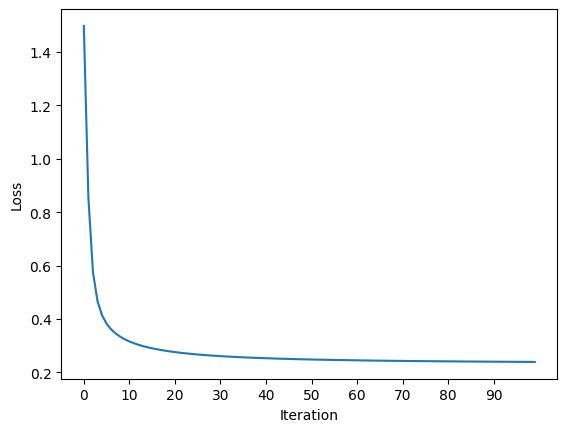

In [250]:
np.random.seed(SEED)

# Adjust softmax to work with multiple samples
softmax = lambda z: np.exp(z) / np.sum(np.exp(z), axis=1, keepdims=True)

# Adjust the number of epochs and the learning rate
num_epochs = 100
learning_rate = 1

# Add a bias term
X_b = np.hstack([X_train, np.ones((X_train.shape[0], 1))])

# Number of samples
num_samples = X_b.shape[0]

# Random weights initialization
W = np.random.normal(size=(X_b.shape[1], num_classes))  # 2 features + 1 bias, 3 classes

iteration = 0
loss_history = []
for epoch in range(num_epochs):
    # Prediction is computed for all samples at once
    Y_pred = softmax(np.dot(X_b, W)) # N x K

    # Loss
    loss_values = -np.log(Y_pred[range(num_samples), y_train])
    loss_value = np.mean(loss_values)
    loss_history.append(loss_value)

    # Gradient computation
    Y_onehot = onehot(y_train, num_classes)  # N x K
    P = Y_pred - Y_onehot # N x K
    grad = np.dot(X_b.T, P) / num_samples # (D+1) x K

    # Alternative way to compute the gradient
    # Y_pred[range(num_samples), y_train] -= 1
    # grad = np.dot(X_b.T, Y_pred) / num_samples # (D+1) x K

    # Update weights
    W = W - learning_rate * grad

    iteration += 1
plot_loss_history(loss_history, interval=iteration // 10)

### Test

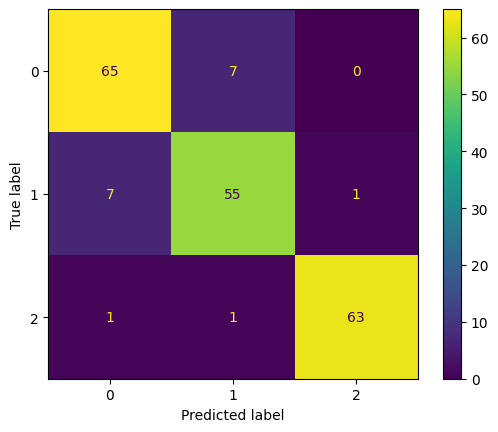


Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.90      0.90        72
           1       0.87      0.87      0.87        63
           2       0.98      0.97      0.98        65

    accuracy                           0.92       200
   macro avg       0.92      0.92      0.92       200
weighted avg       0.92      0.92      0.92       200



In [251]:
X_b = np.hstack([X_test, np.ones((X_test.shape[0], 1))])
y_pred = np.argmax(softmax(np.dot(X_b, W)), axis=1)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=[0, 1, 2])
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

# Compute classification report
class_report = classification_report(y_test, y_pred)

print("\nClassification Report:")
print(class_report)